# Importando Bibliotecas

In [1464]:
# Standard Library
import os
import datetime
import importlib

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Plot
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import optuna
from optuna.trial import TrialState

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente.

In [1465]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU).

In [1466]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Carregando e Processando os Dados

Iremos trabalhar com o valor de fechamento do BTC no dia. Além disso, vamos configurar a coluna de data para ser o index do dataset.

In [1467]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv', index_col='date', parse_dates=True)
dataset

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2024-06-04,1717459200,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
2024-06-03,1717372800,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2024-06-02,1717286400,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
2024-06-01,1717200000,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-05-31,1717113600,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...
2014-12-02,1417478400,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2014-12-01,1417392000,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-11-30,1417305600,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la.

In [1468]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [1469]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [1470]:
# Invertendo o dataset
dataset = dataset.iloc[::-1]

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()

In [1471]:
dataset

,unix,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2014-11-28,1417132800,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...
2024-05-31,1717113600,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
2024-06-01,1717200000,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-06-02,1717286400,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07


Vamos dividir o conjunto de dados em duas partes:
- `x`: contém todas as colunas exceto 'close' e 'unix'
- `y`: contém apenas a coluna 'close'

In [1472]:
x, y = dataset.drop(columns=['close', 'unix']), dataset.close.values
x.shape, y.shape

((3477, 5), (3477,))

Em seguida, normalizamos os dados utilizando:
- `StandardScaler` para x, pois as varíaveis possuem diferentes escalas
- `MinMaxScaler` para y, para evitar problemas de explosão de gradiente e garantir que a rede neural convirja mais rapidamente no treinamento

In [1473]:
# Normaliza os dados
ss = StandardScaler()
mm = MinMaxScaler()

x_trans = ss.fit_transform(x)
y_trans = mm.fit_transform(y.reshape(-1, 1))

# Análise Exploratória

In [1474]:
dataset

,unix,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,
2014-11-28,1417132800,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2014-11-29,1417219200,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2014-11-30,1417305600,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2014-12-01,1417392000,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2014-12-02,1417478400,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...
2024-05-31,1717113600,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
2024-06-01,1717200000,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
2024-06-02,1717286400,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07


Definimos, então, um índice para separação do conjunto de dados em um subconjunto de, respectivamente, treinamento e teste. Vamos pegar 20% do dataset para teste.

In [1475]:
train_test_cutoff = int(len(dataset) * 0.2)

### Visualização do Dataset

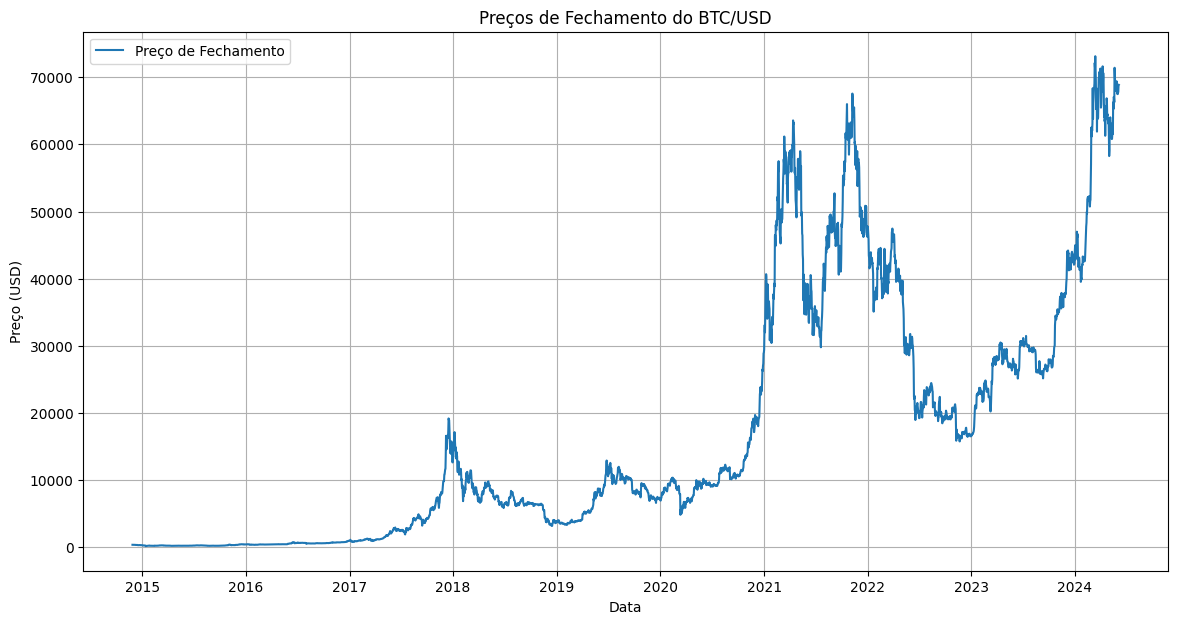

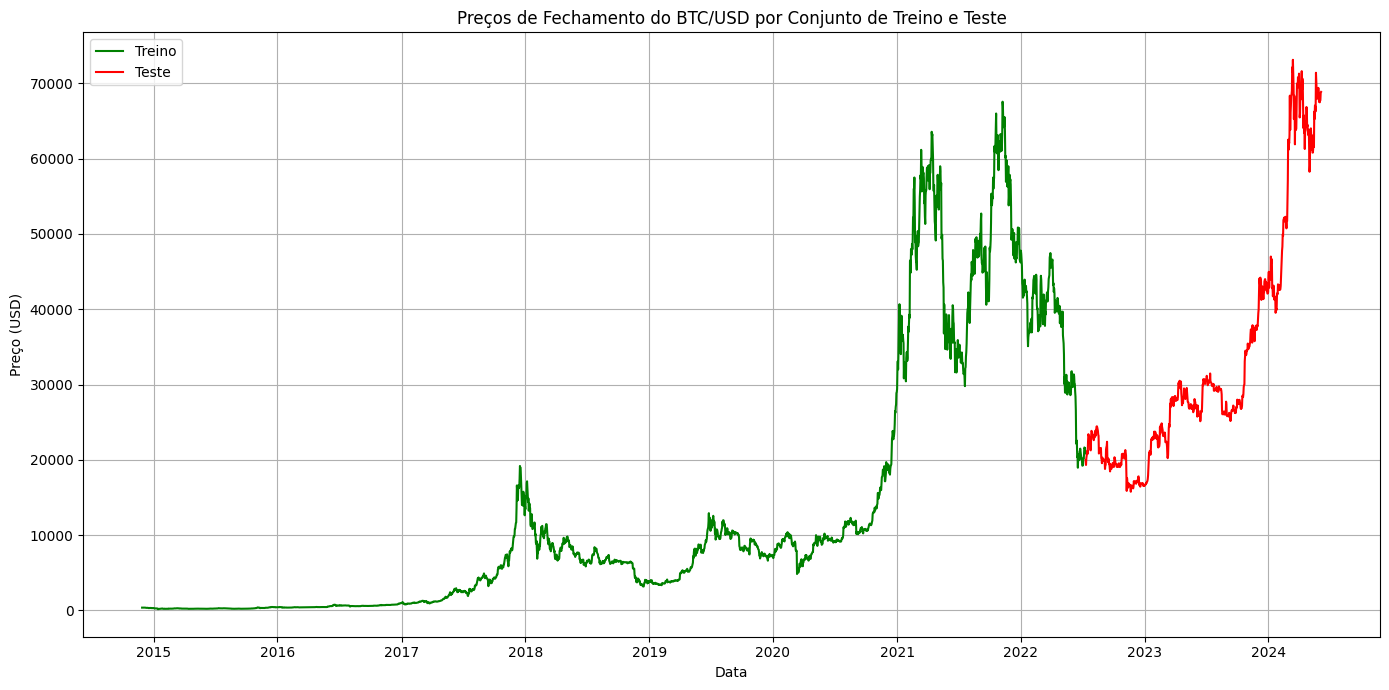

In [1476]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset.iloc[:-train_test_cutoff]['close'], label='Treino', color='green')
plt.plot(dataset.iloc[-train_test_cutoff:]['close'], label='Teste', color='red')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

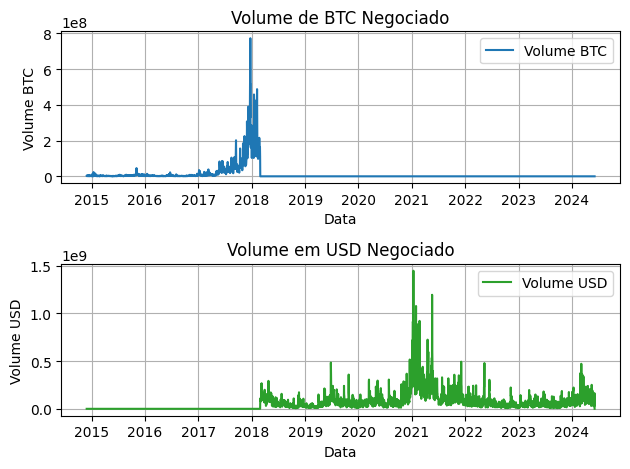

In [1477]:
plt.subplot(2, 1, 1)
plt.plot(dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

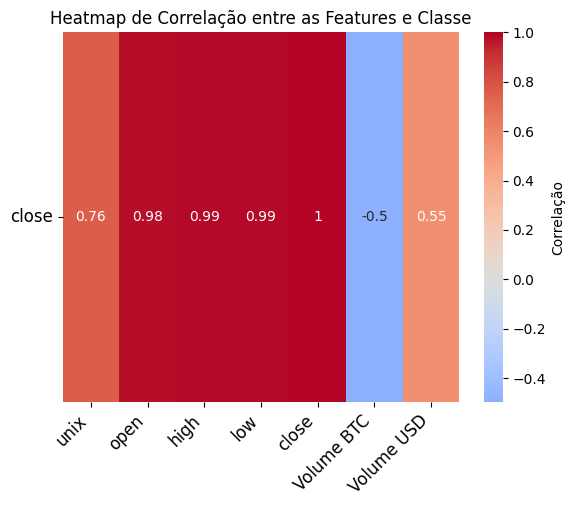

In [1478]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Divisão dos Dados
O próximo passo é dividir os dados em sequências de entrada e saída.

As sequências serão formadas com base em:
- `n_prev_days`: número de dias anteriores, que serão usados como entrada para o modelo de previsão
- `n_next_days`: número de dias seguintes, que serão previstos pelo modelo

In [1479]:
n_prev_days = 100
n_next_days = 50

# Nesse caso, serão usadas 5 informações (open, high, low, volume BTC, volume USD)
# dos últimos 100 dias para prever o preço de fechamento nos próximos 50 dias

Definimos, então, uma função utilitária para essa divisão em sequências. Em seguida, usamos essa função para dividir as partes `x` e `y` dos dados após as transformações anteriormente mencionadas.

In [1480]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    x, y = [], []
    for i in range(len(input_sequences)):
        # Encontrando os últimos índices das sequências de entrada e saída
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out - 1

        # Bounds checking na entrada
        if out_end_idx > len(input_sequences):
            break

        # Pegando as sequências de entrada e saída do padrão
        seq_x, seq_y = input_sequences[i:end_idx], output_sequence[(end_idx - 1):out_end_idx, -1]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)


x_ss, y_mm = split_sequences(x_trans, y_trans, n_prev_days, n_next_days)
print(x_ss.shape, y_mm.shape)

(3329, 100, 5) (3329, 50)


Após essa divisão, os conjuntos de treinamento e teste são criados usando o índice de corte definido anteriormente.

In [1481]:
total_samples = len(x)

x_train = x_ss[:-train_test_cutoff]
x_test = x_ss[-train_test_cutoff:]

y_train = y_mm[:-train_test_cutoff]
y_test = y_mm[-train_test_cutoff:]

Training Shape: (2634, 100, 5) (2634, 50)
Testing Shape: (695, 100, 5) (695, 50)


Convertemos, então, os dados de treinamento e teste para tensores do *PyTorch*, para que o modelo possa usá-los devidamente.

In [1482]:
x_train_tensors = torch.Tensor(x_train)
x_test_tensors = torch.Tensor(x_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

Também é necessário adaptar a forma dos tensores. A nova estrutura será do tipo:

[*número de amostras*, *número e dias anteriores*, *número de características*]

In [1483]:
x_train_tensors_final = torch.reshape(x_train_tensors,   
                                      (x_train_tensors.shape[0],
                                       n_prev_days,
                                       x_train_tensors.shape[2]))
x_test_tensors_final = torch.reshape(x_test_tensors,  
                                     (x_test_tensors.shape[0],
                                      n_prev_days,
                                      x_test_tensors.shape[2]))

Training Shape: torch.Size([2634, 100, 5]) torch.Size([2634, 50])
Testing Shape: torch.Size([695, 100, 5]) torch.Size([695, 50])


In [1485]:
x_train, y_train

(array([[[-0.8952886 , -0.89532915, -0.89468832, -0.16654334,
          -0.64150103],
         [-0.89459062, -0.89504987, -0.89403503, -0.17796782,
          -0.64151502],
         [-0.89458245, -0.89529464, -0.89397518, -0.21648709,
          -0.64155782],
         ...,
         [-0.90038938, -0.9006833 , -0.90019038, -0.17016407,
          -0.64147307],
         [-0.90017341, -0.9008978 , -0.89981004, -0.19815042,
          -0.64151755],
         [-0.90020278, -0.90073746, -0.89975411, -0.20697649,
          -0.64153173]],
 
        [[-0.89459062, -0.89504987, -0.89403503, -0.17796782,
          -0.64151502],
         [-0.89458245, -0.89529464, -0.89397518, -0.21648709,
          -0.64155782],
         [-0.8945917 , -0.89527764, -0.8939914 , -0.1833945 ,
          -0.64152098],
         ...,
         [-0.90017341, -0.9008978 , -0.89981004, -0.19815042,
          -0.64151755],
         [-0.90020278, -0.90073746, -0.89975411, -0.20697649,
          -0.64153173],
         [-0.90007603, 

In [1486]:
x_test, y_test

(array([[[ 1.38249738e+00,  1.35582774e+00,  1.42773242e+00,
          -2.44043500e-01, -4.20497568e-01],
         [ 1.37411123e+00,  1.36071677e+00,  1.41053099e+00,
          -2.44025320e-01, -9.04828043e-02],
         [ 1.40069994e+00,  1.46234050e+00,  1.46058819e+00,
          -2.44013238e-01,  1.64127211e-01],
         ...,
         [ 6.72218552e-01,  6.57165800e-01,  7.02410850e-01,
          -2.44044102e-01, -4.94506456e-01],
         [ 6.84385142e-01,  7.01583904e-01,  7.18873414e-01,
          -2.44024164e-01, -2.34702051e-01],
         [ 7.31406369e-01,  7.10632439e-01,  6.98192993e-01,
          -2.44003955e-01, -1.66120765e-03]],
 
        [[ 1.37411123e+00,  1.36071677e+00,  1.41053099e+00,
          -2.44025320e-01, -9.04828043e-02],
         [ 1.40069994e+00,  1.46234050e+00,  1.46058819e+00,
          -2.44013238e-01,  1.64127211e-01],
         [ 1.51078244e+00,  1.45199166e+00,  1.50773188e+00,
          -2.44025778e-01, -8.13752877e-02],
         ...,
         [ 6.84

# Definindo a classe LSTM
Como modelo de previsão, vamos usar uma rede neural com um número variável de camadas LSTM e duas camadas Fully Connected.

O método `forward` implementa o *forward pass* da rede. Ele propaga a entrada através da camada LSTM, aplicando funções de ativação ReLU entre as camadas Fully Connected. Por fim, retorna a saída da rede.

Ainda nesse método, as variáveis com prefixo `h` (`h0` e `hn`) representam o estado da célula LSTM que é atualizada e passada para cada passo de tempo subsequente durante a execução. Ele captura informações relevantes sobre os dados de entrada até o momento atual.

Já as variáveis com prefixo `c` (`c0` e `cn`) representam a o estado da célula de memória. Assim como o estado oculto, ele matém informações relevantes de longo prazo sobre os dados de entrada.

In [1487]:
class LSTM(nn.Module):
    input_size = 5

    def __init__(self, n_classes, hidden_size, n_layers, n_neurons, dropout_rate):
        super().__init__()

        self.n_classes = n_classes
        self.hidden_size = hidden_size 
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=hidden_size,
                            num_layers=n_layers, batch_first=True,
                            dropout=(dropout_rate if n_layers > 1 else 0))
        self.fc1 = nn.Linear(hidden_size, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_classes)


    def forward(self, x):
        # Estado Oculto
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        # Estato de Célula
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        hn = hn[-1, :, :]
        out = F.relu(hn)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

# Definindo funções úteis
Aqui definimos as funções de treinamento de teste do modelo para 1 único epoch.

In [1488]:
def train_model(model, criterion, optimizer, x_train, y_train):
    model.train().to(device)

    outputs = model(x_train)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    return loss

In [1489]:
def test_model(model, criterion, x_test, y_test):
    model.eval().to(device)

    with torch.no_grad():
        outputs = model(x_test)
        loss = criterion(outputs, y_test)

    return loss

# Fine-Tuning de Hiperparâmetros

In [1490]:
ModelClass = LSTM
n_epochs = 100
n_trials = 10
criterion = nn.MSELoss().to(device)

In [1491]:
def objective(trial):
    trial.set_user_attr('network', ModelClass.__name__)
    trial.set_user_attr('total_epochs', n_epochs)

    hidden_size = trial.suggest_int("hidden_size", 2, 4)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_neurons = trial.suggest_int("n_neurons", 100, 200, step=10)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.9, step=0.1)

    model = ModelClass(n_next_days, hidden_size, n_layers, n_neurons, dropout_rate)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)

    for epoch in range(n_epochs):
        train_loss = train_model(model, criterion, optimizer,
                                x_train_tensors_final, y_train_tensors)
        test_loss = test_model(model, criterion,
                            x_test_tensors_final, y_test_tensors)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Pruning (stops trial early if not promising)
        trial.report(test_loss, epoch)
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join("models", f"cnn_{current_datetime}.pth")
    torch.save(model.state_dict(), model_path)

    trial.set_user_attr("model_path", model_path)

    return test_loss

In [1492]:
study = optuna.create_study(study_name="BTC-LSTM", direction="minimize")

study.optimize(objective, n_trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])

[I 2024-06-11 19:46:49,182] A new study created in memory with name: BTC-LSTM


Epoch 1, Train Loss: 0.1086, Test Loss: 1.6109
Epoch 2, Train Loss: 2.0603, Test Loss: 0.1004
Epoch 3, Train Loss: 0.1747, Test Loss: 0.5329
Epoch 4, Train Loss: 0.3062, Test Loss: 1.1311
Epoch 5, Train Loss: 0.7794, Test Loss: 1.0392
Epoch 6, Train Loss: 0.7030, Test Loss: 0.6492
Epoch 7, Train Loss: 0.3914, Test Loss: 0.3284
Epoch 8, Train Loss: 0.1600, Test Loss: 0.1584
Epoch 9, Train Loss: 0.0661, Test Loss: 0.0935
Epoch 10, Train Loss: 0.0553, Test Loss: 0.0794
Epoch 11, Train Loss: 0.0703, Test Loss: 0.0813
Epoch 12, Train Loss: 0.0796, Test Loss: 0.0832
Epoch 13, Train Loss: 0.0716, Test Loss: 0.0824
Epoch 14, Train Loss: 0.0536, Test Loss: 0.1000
Epoch 15, Train Loss: 0.0474, Test Loss: 0.1112
Epoch 16, Train Loss: 0.0492, Test Loss: 0.0935
Epoch 17, Train Loss: 0.0391, Test Loss: 0.0793
Epoch 18, Train Loss: 0.0434, Test Loss: 0.0776
Epoch 19, Train Loss: 0.0461, Test Loss: 0.0778
Epoch 20, Train Loss: 0.0402, Test Loss: 0.0800
Epoch 21, Train Loss: 0.0376, Test Loss: 0.0816
E

[I 2024-06-11 19:47:05,387] Trial 0 finished with value: 0.05088626593351364 and parameters: {'hidden_size': 2, 'n_layers': 2, 'n_neurons': 190, 'dropout_rate': 0.6, 'optimizer': 'Adam', 'lr': 0.05241189162539966}. Best is trial 0 with value: 0.05088626593351364.


Epoch 100, Train Loss: 0.0064, Test Loss: 0.0509
Epoch 1, Train Loss: 0.0956, Test Loss: 2626.7212
Epoch 2, Train Loss: 2527.5613, Test Loss: 13.7182
Epoch 3, Train Loss: 12.1175, Test Loss: 1.2196
Epoch 4, Train Loss: 1.7314, Test Loss: 0.1296
Epoch 5, Train Loss: 0.0586, Test Loss: 0.1283
Epoch 6, Train Loss: 0.0582, Test Loss: 0.1271
Epoch 7, Train Loss: 0.0578, Test Loss: 0.1260
Epoch 8, Train Loss: 0.0575, Test Loss: 0.1249
Epoch 9, Train Loss: 0.0572, Test Loss: 0.1239
Epoch 10, Train Loss: 0.0569, Test Loss: 0.1229
Epoch 11, Train Loss: 0.0566, Test Loss: 0.1220
Epoch 12, Train Loss: 0.0563, Test Loss: 0.1211
Epoch 13, Train Loss: 0.0561, Test Loss: 0.1202
Epoch 14, Train Loss: 0.0559, Test Loss: 0.1194
Epoch 15, Train Loss: 0.0557, Test Loss: 0.1186
Epoch 16, Train Loss: 0.0555, Test Loss: 0.1179
Epoch 17, Train Loss: 0.0554, Test Loss: 0.1172
Epoch 18, Train Loss: 0.0552, Test Loss: 0.1165
Epoch 19, Train Loss: 0.0551, Test Loss: 0.1159
Epoch 20, Train Loss: 0.0549, Test Loss:

[I 2024-06-11 19:47:33,564] Trial 1 finished with value: 0.1033468022942543 and parameters: {'hidden_size': 4, 'n_layers': 3, 'n_neurons': 160, 'dropout_rate': 0.6, 'optimizer': 'RMSprop', 'lr': 0.07856407181265529}. Best is trial 0 with value: 0.05088626593351364.


Epoch 100, Train Loss: 0.0535, Test Loss: 0.1033
Epoch 1, Train Loss: 0.1062, Test Loss: 0.1970
Epoch 2, Train Loss: 0.0826, Test Loss: 0.1545
Epoch 3, Train Loss: 0.0663, Test Loss: 0.1213
Epoch 4, Train Loss: 0.0554, Test Loss: 0.0961
Epoch 5, Train Loss: 0.0483, Test Loss: 0.0776
Epoch 6, Train Loss: 0.0437, Test Loss: 0.0644
Epoch 7, Train Loss: 0.0408, Test Loss: 0.0553
Epoch 8, Train Loss: 0.0388, Test Loss: 0.0491
Epoch 9, Train Loss: 0.0370, Test Loss: 0.0448
Epoch 10, Train Loss: 0.0351, Test Loss: 0.0414
Epoch 11, Train Loss: 0.0329, Test Loss: 0.0385
Epoch 12, Train Loss: 0.0303, Test Loss: 0.0356
Epoch 13, Train Loss: 0.0275, Test Loss: 0.0326
Epoch 14, Train Loss: 0.0246, Test Loss: 0.0296
Epoch 15, Train Loss: 0.0218, Test Loss: 0.0266
Epoch 16, Train Loss: 0.0193, Test Loss: 0.0239
Epoch 17, Train Loss: 0.0171, Test Loss: 0.0217
Epoch 18, Train Loss: 0.0154, Test Loss: 0.0200
Epoch 19, Train Loss: 0.0141, Test Loss: 0.0189
Epoch 20, Train Loss: 0.0132, Test Loss: 0.0181


[I 2024-06-11 19:47:42,311] Trial 2 finished with value: 0.008626073598861694 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 170, 'dropout_rate': 0.9, 'optimizer': 'Adam', 'lr': 0.0025680531096877067}. Best is trial 2 with value: 0.008626073598861694.


Epoch 99, Train Loss: 0.0029, Test Loss: 0.0086
Epoch 100, Train Loss: 0.0029, Test Loss: 0.0086
Epoch 1, Train Loss: 0.1122, Test Loss: 0.1689
Epoch 2, Train Loss: 0.0764, Test Loss: 0.1197
Epoch 3, Train Loss: 0.0612, Test Loss: 0.0912
Epoch 4, Train Loss: 0.0562, Test Loss: 0.0772
Epoch 5, Train Loss: 0.0542, Test Loss: 0.0713
Epoch 6, Train Loss: 0.0517, Test Loss: 0.0693
Epoch 7, Train Loss: 0.0481, Test Loss: 0.0687
Epoch 8, Train Loss: 0.0440, Test Loss: 0.0679
Epoch 9, Train Loss: 0.0398, Test Loss: 0.0657
Epoch 10, Train Loss: 0.0358, Test Loss: 0.0617
Epoch 11, Train Loss: 0.0317, Test Loss: 0.0560
Epoch 12, Train Loss: 0.0275, Test Loss: 0.0491
Epoch 13, Train Loss: 0.0233, Test Loss: 0.0420
Epoch 14, Train Loss: 0.0193, Test Loss: 0.0355
Epoch 15, Train Loss: 0.0158, Test Loss: 0.0304
Epoch 16, Train Loss: 0.0131, Test Loss: 0.0271
Epoch 17, Train Loss: 0.0113, Test Loss: 0.0255
Epoch 18, Train Loss: 0.0106, Test Loss: 0.0251
Epoch 19, Train Loss: 0.0105, Test Loss: 0.0249


[I 2024-06-11 19:47:50,733] Trial 3 finished with value: 0.008790518157184124 and parameters: {'hidden_size': 3, 'n_layers': 1, 'n_neurons': 120, 'dropout_rate': 0.30000000000000004, 'optimizer': 'Adam', 'lr': 0.007061143351158621}. Best is trial 2 with value: 0.008626073598861694.


Epoch 98, Train Loss: 0.0027, Test Loss: 0.0087
Epoch 99, Train Loss: 0.0027, Test Loss: 0.0088
Epoch 100, Train Loss: 0.0027, Test Loss: 0.0088
Epoch 1, Train Loss: 0.1145, Test Loss: 0.2454
Epoch 2, Train Loss: 0.1111, Test Loss: 0.2396
Epoch 3, Train Loss: 0.1079, Test Loss: 0.2339
Epoch 4, Train Loss: 0.1048, Test Loss: 0.2283
Epoch 5, Train Loss: 0.1019, Test Loss: 0.2230
Epoch 6, Train Loss: 0.0991, Test Loss: 0.2177
Epoch 7, Train Loss: 0.0964, Test Loss: 0.2127
Epoch 8, Train Loss: 0.0939, Test Loss: 0.2078
Epoch 9, Train Loss: 0.0914, Test Loss: 0.2030
Epoch 10, Train Loss: 0.0891, Test Loss: 0.1984
Epoch 11, Train Loss: 0.0869, Test Loss: 0.1939
Epoch 12, Train Loss: 0.0848, Test Loss: 0.1896
Epoch 13, Train Loss: 0.0828, Test Loss: 0.1855
Epoch 14, Train Loss: 0.0809, Test Loss: 0.1814
Epoch 15, Train Loss: 0.0791, Test Loss: 0.1775
Epoch 16, Train Loss: 0.0774, Test Loss: 0.1738
Epoch 17, Train Loss: 0.0758, Test Loss: 0.1701
Epoch 18, Train Loss: 0.0743, Test Loss: 0.1666


[I 2024-06-11 19:47:59,406] Trial 4 finished with value: 0.0953788161277771 and parameters: {'hidden_size': 2, 'n_layers': 1, 'n_neurons': 190, 'dropout_rate': 0.4, 'optimizer': 'Adam', 'lr': 0.0002566068225723112}. Best is trial 2 with value: 0.008626073598861694.
[I 2024-06-11 19:47:59,509] Trial 5 pruned. 


Epoch 100, Train Loss: 0.0433, Test Loss: 0.0954
Epoch 1, Train Loss: 0.1206, Test Loss: 0.2695
Epoch 1, Train Loss: 0.1108, Test Loss: 0.1982


[I 2024-06-11 19:48:00,015] Trial 6 pruned. 
[I 2024-06-11 19:48:00,110] Trial 7 pruned. 


Epoch 2, Train Loss: 0.0858, Test Loss: 0.1565
Epoch 1, Train Loss: 0.1000, Test Loss: 2.0743


[I 2024-06-11 19:48:00,512] Trial 8 pruned. 


Epoch 1, Train Loss: 0.1030, Test Loss: 0.2329
Epoch 2, Train Loss: 0.0988, Test Loss: 0.2233


[I 2024-06-11 19:48:00,714] Trial 9 pruned. 


Epoch 1, Train Loss: 0.1081, Test Loss: 0.2486


In [1493]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values("value") # Sort based on test loss

csv_file = "results.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [1494]:
print("\n-- Study Statistics --")
print(f"  Number of trials:        {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")

best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Test Loss: {(best_trial.value):.4f}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(12 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by Accuracy) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(12 - len(key)) * ' '}{(100 * val):.2f}%")


-- Study Statistics --
  Number of trials:        10
  Number of pruned trials: 5

-- Best Trial --
  Test Loss: 0.0086
  Parameters: 
    hidden_size:  3
    n_layers:     1
    n_neurons:    170
    dropout_rate: 0.9
    optimizer:    Adam
    lr:           0.0025680531096877067

-- Overall Results (Ordered by Accuracy) --
   number     value  params_dropout_rate  params_hidden_size  params_lr  \
2       2  0.008626                  0.9                   3   0.002568   
3       3  0.008791                  0.3                   3   0.007061   
0       0  0.050886                  0.6                   2   0.052412   
4       4  0.095379                  0.4                   2   0.000257   
1       1  0.103347                  0.6                   4   0.078564   

   params_n_layers  params_n_neurons params_optimizer  \
2                1               170             Adam   
3                1               120             Adam   
0                2               190             A

In [1495]:
best_model_path = best_trial.user_attrs["model_path"]
csv_path = "results.csv"

df = pd.read_csv(csv_path)
row = df[df["user_attrs_model_path"] == best_model_path]
class_name = row["user_attrs_network"].iloc[0]

ModelClass = getattr(importlib.import_module("__main__"), class_name)

best_hidden_size = best_trial.params["hidden_size"]
best_n_layers = best_trial.params["n_layers"]
best_n_neurons = best_trial.params["n_neurons"]
best_dropout_rate = best_trial.params["dropout_rate"]

best_model = ModelClass(n_next_days, best_hidden_size, best_n_layers, best_n_neurons, best_dropout_rate).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

LSTM(
  (lstm): LSTM(5, 3, batch_first=True)
  (fc1): Linear(in_features=3, out_features=170, bias=True)
  (fc2): Linear(in_features=170, out_features=50, bias=True)
)

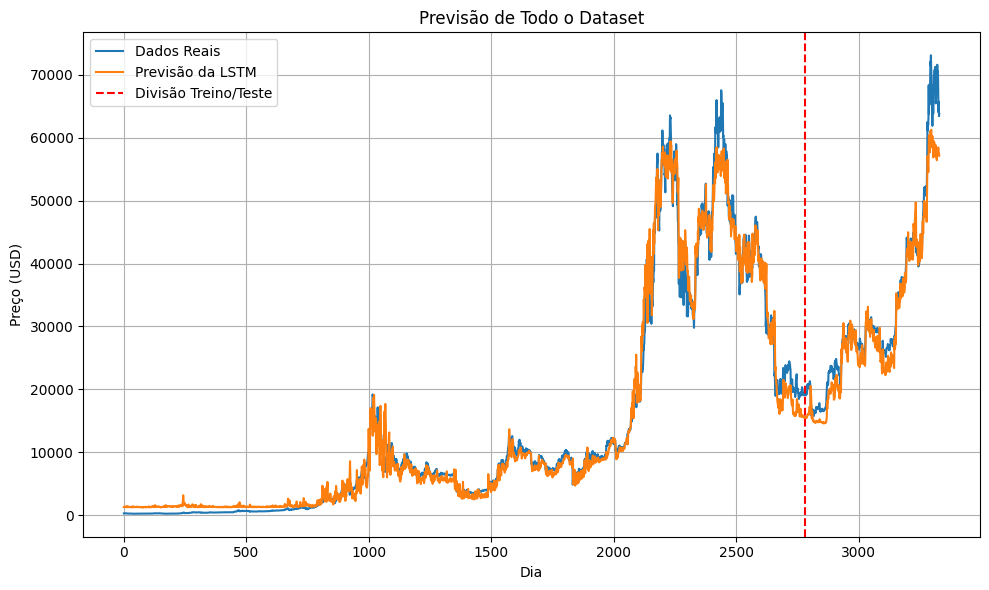

In [1496]:
dataset_x_ss = ss.transform(dataset.drop(columns=['close', 'unix']))
dataset_y_mm = mm.transform(dataset.close.values.reshape(-1, 1))
# Split the sequence
dataset_x_ss, dataset_y_mm = split_sequences(dataset_x_ss, dataset_y_mm, n_prev_days, n_next_days)
# Converting to tensors
dataset_x_ss = torch.Tensor(dataset_x_ss)
datatset_y_mm = torch.Tensor(dataset_y_mm)
# Reshaping the dataset
dataset_x_ss = torch.reshape(dataset_x_ss, (dataset_x_ss.shape[0], n_prev_days, dataset_x_ss.shape[2]))

train_predict = best_model(dataset_x_ss) # Forward pass
data_predict = train_predict.detach().numpy() # Numpy conversion
dataY_plot = dataset_y_mm

data_predict = mm.inverse_transform(data_predict) # Reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10, 6))

plt.plot(true, label='Dados Reais')
plt.plot(preds, label='Previsão da LSTM')
plt.title('Previsão de Todo o Dataset')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.axvline(x=(len(dataset) - train_test_cutoff), c='r', linestyle='--', label='Divisão Treino/Teste')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show() 

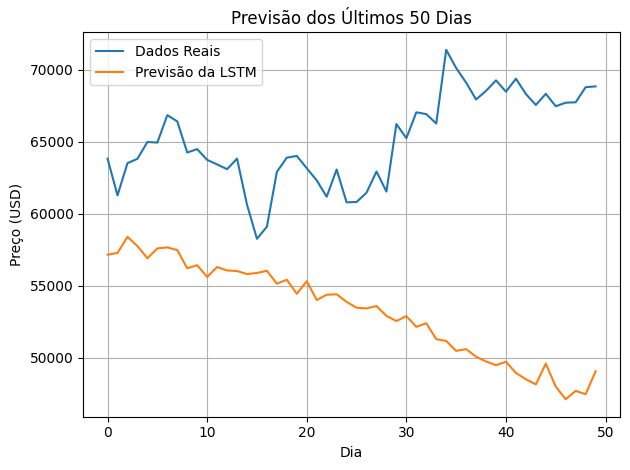

In [1497]:
test_predict = best_model(x_test_tensors_final[-1].unsqueeze(0)) # Get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # Last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label='Dados Reais')
plt.plot(test_predict, label='Previsão da LSTM')
plt.title(f'Previsão dos Últimos {n_next_days} Dias')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

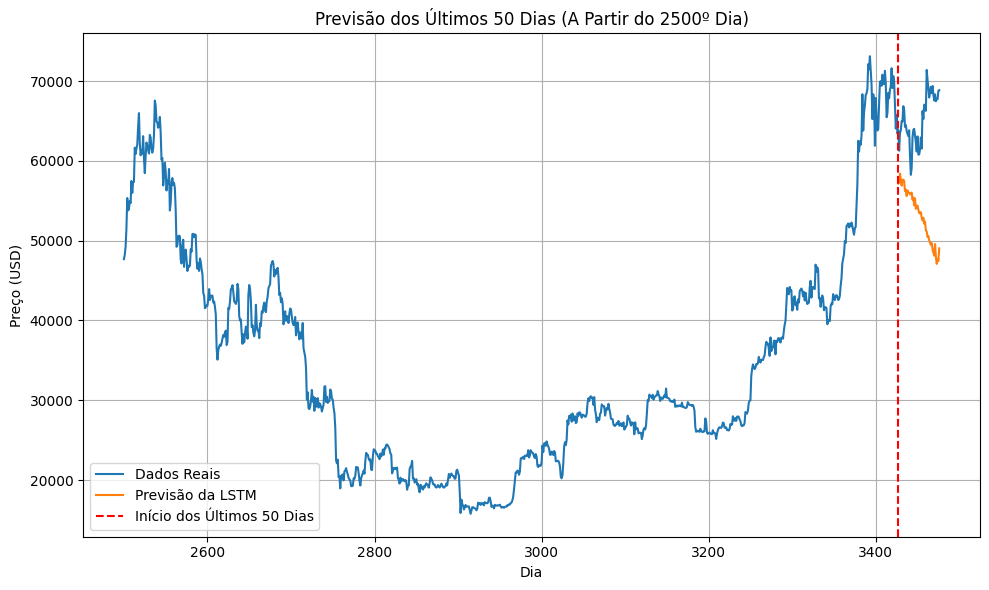

In [1498]:
plt.figure(figsize=(10, 6))
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Dados Reais')
c = [x for x in range(len(y) - n_next_days, len(y))]
plt.plot(c, test_predict, label='Previsão da LSTM')
plt.title(f'Previsão dos Últimos {n_next_days} Dias (A Partir do 2500º Dia)')
plt.xlabel('Dia')
plt.ylabel('Preço (USD)')
plt.axvline(x=(len(y) - n_next_days), c='r', linestyle='--', label='Início dos Últimos 50 Dias')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()